<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [69]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [70]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

# Ans:
## <font color = 'green'>Starting Note:</font>
This question is about prediction from a linear model



In [71]:
# Load the data
house = pd.read_csv('./housing.csv')

### Understanding the overall dataset

In [72]:
#A. 
## Understanding Shape

house.shape

(1460, 81)

In [73]:
## Understanding how the variables and values look like in the dataframe

house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [74]:
## Getting any overview of the types of each variable and a prelimary scan of null value spread

house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

#### <u>Carrying part of the goals to remove any houses that are not residential from the dataset.</u>

In [75]:
## Finding out how many non-residential houses are in the dataset

house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [76]:
## Final visual scan of commercial(C (all))/ non-residential rows to ensure that we are not missing out on important or misclassfied data

house[house['MSZoning']=='C (all)']

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
30      31          70  C (all)         50.0     8500   Pave  Pave      Reg   
88      89          50  C (all)        105.0     8470   Pave   NaN      IR1   
93      94         190  C (all)         60.0     7200   Pave   NaN      Reg   
495    496          30  C (all)         60.0     7879   Pave   NaN      Reg   
557    558          50  C (all)         60.0    11040   Pave   NaN      Reg   
711    712          50  C (all)         66.0     8712   Pave  Pave      Reg   
812    813          20  C (all)         66.0     8712   Grvl   NaN      Reg   
916    917          20  C (all)         50.0     9000   Pave   NaN      Reg   
1061  1062          30  C (all)        120.0    18000   Grvl   NaN      Reg   
1279  1280          50  C (all)         60.0     7500   Pave   NaN      Reg   

     LandContour Utilities    ...     PoolArea PoolQC  Fence MiscFeature  \
30           Lvl    AllPub    ...            0    NaN  MnPrv         NaN   
88           Lvl    AllPub    ...            0    NaN  MnPrv         NaN   
93           Lvl    AllPub    ...            0    NaN    NaN         NaN   
495          Lvl    AllPub    ...            0    NaN   GdWo         NaN   
557          Low    AllPub    ...            0    NaN    NaN         NaN   
711          HLS    AllPub    ...            0    NaN    NaN         NaN   
812          Bnk    AllPub    ...            0    NaN    NaN        Shed   
916          Lvl    AllPub    ...            0    NaN    NaN         NaN   
1061         Low    AllPub    ...            0    NaN    NaN        Shed   
1279         Lvl    AllPub    ...            0    NaN    NaN         NaN   

     MiscVal MoSold YrSold  SaleType  SaleCondition  SalePrice  
30         0      7   2008        WD         Normal      40000  
88         0     10   2009     ConLD        Abnorml      85000  
93         0     11   2007        WD         Normal     133900  
495        0     11   2009        WD        Abnorml      34900  
557        0      9   2006       COD         Normal     108000  
711        0      1   2010        WD        Abnorml     102776  
812       54      6   2010        WD         Alloca      55993  
916        0     10   2006        WD        Abnorml      35311  
1061     560      8   2008     ConLD         Normal      81000  
1279       0      4   2010       COD        Abnorml      68400  

[10 rows x 81 columns]

In [77]:
## Removing the houses that are not residential
## That means, removing houses with 'MSZoning' == 'C (all)'

house.drop(house[house['MSZoning']=='C (all)'].index,axis=0,inplace=True)   # dropping all C (call) rows

house.index=range(0,house.shape[0])    # resetting the index

--------------------------------------------------
### <u>Investigation 1: columns with high null values</u>

Columns of note will be 'Alley, FireplaceQU, PoolQC, Fence,MiscFeature'

In [78]:
## Checking null values in Alley column

house[house['Alley'].isnull()]

## There are 1360 null values

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
5        6          50       RL         85.0    14115   Pave   NaN      IR1   
6        7          20       RL         75.0    10084   Pave   NaN      Reg   
7        8          60       RL          NaN    10382   Pave   NaN      IR1   
8        9          50       RM         51.0     6120   Pave   NaN      Reg   
9       10         190       RL         50.0     7420   Pave   NaN      Reg   
10      11          20       RL         70.0    11200   Pave   NaN      Reg   
11      12          60       RL         85.0    11924   Pave   NaN      IR1   
12      13          20       RL          NaN    12968   Pave   NaN      IR2   
13      14          20       RL         91.0    10652   Pave   NaN      IR1   
14      15          20       RL          NaN    10920   Pave   NaN      IR1   
15      16          45       RM         51.0     6120   Pave   NaN      Reg   
16      17          20       RL          NaN    11241   Pave   NaN      IR1   
17      18          90       RL         72.0    10791   Pave   NaN      Reg   
18      19          20       RL         66.0    13695   Pave   NaN      Reg   
19      20          20       RL         70.0     7560   Pave   NaN      Reg   
20      21          60       RL        101.0    14215   Pave   NaN      IR1   
22      23          20       RL         75.0     9742   Pave   NaN      Reg   
23      24         120       RM         44.0     4224   Pave   NaN      Reg   
24      25          20       RL          NaN     8246   Pave   NaN      IR1   
25      26          20       RL        110.0    14230   Pave   NaN      Reg   
26      27          20       RL         60.0     7200   Pave   NaN      Reg   
27      28          20       RL         98.0    11478   Pave   NaN      Reg   
28      29          20       RL         47.0    16321   Pave   NaN      IR1   
29      30          30       RM         60.0     6324   Pave   NaN      IR1   
30      32          20       RL          NaN     8544   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1418  1429          30       RM         60.0     7200   Pave   NaN      Reg   
1419  1430          20       RL          NaN    12546   Pave   NaN      IR1   
1420  1431          60       RL         60.0    21930   Pave   NaN      IR3   
1421  1432         120       RL          NaN     4928   Pave   NaN      IR1   
1423  1434          60       RL         93.0    10261   Pave   NaN      IR1   
1424  1435          20       RL         80.0    17400   Pave   NaN      Reg   
1425  1436          20       RL         80.0     8400   Pave   NaN      Reg   
1426  1437          20       RL         60.0     9000   Pave   NaN      Reg   
1427  1438          20       RL         96.0    12444   Pave   NaN      Reg   
1428  1439          20       RM         90.0     7407   Pave   NaN      Reg   
1429  1440          60       RL         80.0    11584   Pave   NaN      Reg   
1430  1441          70       RL         79.0    11526   Pave   NaN      IR1   
1431  1442         120       RM          NaN     4426   Pave   NaN      Reg   
1432  1443          60       FV         85.0    11003   Pave   NaN      Reg   
1433  1444          30       RL          NaN     8854   Pave   NaN      Reg   
1434  1445          20       RL         63.0     8500   Pave   NaN      Reg   
1435  1446          85       RL         70.0     8400   Pave   NaN      Reg   
1436  1447          20       RL          NaN    26142   Pave   NaN      IR1   
1437  1448          60       RL         80.0    10000   Pa

#### Alley column: Preliminary conclusions 

1) The reader misinterpreted NA(No alley access) for null and inputted NaN. We can still leave NaN as be and ignore it.<br>
2) NaN category can be used as a baseline when dummy coding, i.e baseline is having no Alley access

In [79]:
## Checking null values in FireplaceQu

house[house['FireplaceQu'].isnull()]

## There are 681 null values

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
5        6          50       RL         85.0    14115   Pave   NaN      IR1   
10      11          20       RL         70.0    11200   Pave   NaN      Reg   
12      13          20       RL          NaN    12968   Pave   NaN      IR2   
15      16          45       RM         51.0     6120   Pave   NaN      Reg   
17      18          90       RL         72.0    10791   Pave   NaN      Reg   
18      19          20       RL         66.0    13695   Pave   NaN      Reg   
19      20          20       RL         70.0     7560   Pave   NaN      Reg   
26      27          20       RL         60.0     7200   Pave   NaN      Reg   
29      30          30       RM         60.0     6324   Pave   NaN      IR1   
30      32          20       RL          NaN     8544   Pave   NaN      IR1   
31      33          20       RL         85.0    11049   Pave   NaN      Reg   
35      37          20       RL        112.0    10859   Pave   NaN      Reg   
37      39          20       RL         68.0     7922   Pave   NaN      Reg   
38      40          90       RL         65.0     6040   Pave   NaN      Reg   
41      43          85       RL          NaN     9180   Pave   NaN      IR1   
42      44          20       RL          NaN     9200   Pave   NaN      IR1   
43      45          20       RL         70.0     7945   Pave   NaN      Reg   
46      48          20       FV         84.0    11096   Pave   NaN      Reg   
47      49         190       RM         33.0     4456   Pave   NaN      Reg   
48      50          20       RL         66.0     7742   Pave   NaN      Reg   
49      51          60       RL          NaN    13869   Pave   NaN      IR2   
51      53          90       RM        110.0     8472   Grvl   NaN      IR2   
55      57         160       FV         24.0     2645   Pave  Pave      Reg   
56      58          60       RL         89.0    11645   Pave   NaN      IR1   
58      60          20       RL         60.0     7200   Pave   NaN      Reg   
59      61          20       RL         63.0    13072   Pave   NaN      Reg   
60      62          75       RM         60.0     7200   Pave   NaN      Reg   
62      64          70       RM         50.0    10300   Pave   NaN      IR1   
63      65          60       RL          NaN     9375   Pave   NaN      Reg   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1381  1392          90       RL         65.0     8944   Pave   NaN      Reg   
1387  1398          70       RM         51.0     6120   Pave   NaN      Reg   
1388  1399          50       RL         60.0     7200   Pave   NaN      Reg   
1393  1404          20       RL         49.0    15256   Pave   NaN      IR1   
1394  1405          50       RL         60.0    10410   Pave  Grvl      Reg   
1396  1407          85       RL         70.0     8445   Pave   NaN      Reg   
1397  1408          20       RL          NaN     8780   Pave   NaN      IR1   
1398  1409          70       RM         60.0     7740   Pave   NaN      Reg   
1400  1411          60       RL         79.0    12420   Pave   NaN      Reg   
1401  1412          50       RL         80.0     9600   Pave   NaN      Reg   
1402  1413          90       RL         60.0     7200   Pave   NaN      Reg   
1406  1417         190       RM         60.0    11340   Pave   NaN      Reg   
1408  1419          20       RL         71.0     9204   Pave   NaN      Reg   
1412  1423         120       RM         37.0     4435   Pave   NaN      Reg   
1415  1426          20       RL         80.0    10721   Pave   NaN      IR1   
1421  1432         120       RL          NaN     4928   Pave   NaN      IR1   
1422  1433          30       RL         60.0    10800   Pave  Grvl      Reg   
1426  1437          20       RL         60.0     9000   Pave   NaN      Reg   
1428  1439          20       RM         90.0     7407   Pa

In [88]:
house[['Fireplaces','FireplaceQu']].sample(5)

Fireplaces FireplaceQu
844            1          TA
201            0         NaN
1182           0         NaN
340            1          Ex
501            0         NaN

#### FireplaceQu column: Preliminary conclusions 
1) It can be concluded that FireplaceQU (Fireplace quality) is Null when there is no Fireplaces. <br>
2) This makes sense and we will leave those null values as it is, for the same reason as for Alley

In [89]:
## Checking null values in PoolQC

house[['PoolArea','PoolQC']].sample(5)

PoolArea PoolQC
579          0    NaN
1088         0    NaN
936          0    NaN
1089         0    NaN
959          0    NaN

In [90]:
## Getting an idea of how many values are NOT null

house[~house['PoolQC'].isnull()].loc[:,'PoolArea':'PoolQC'].shape

(7, 2)

#### PoolQC column: Preliminary conclusions 

1) Similar to Fireplaces, null values in PoolQC are due to not having any pool at all<br>
2) The number of houses with pools is very small, and most houses have no pools<br>
3) We shall leave the null values as be for the same reason as the previous conclusions above

In [91]:
## Checking MasVnrArea null value

house[house['MasVnrType'].isnull()][['MasVnrType','MasVnrArea']]

Empty DataFrame
Columns: [MasVnrType, MasVnrArea]
Index: []

#### MasVnrArea column: Preliminary conclusions 

1) We see that MasVnrType null values corresponds to instances when MasVnrArea is null too<br>
2) Possible error in data recording/logging<br>
3) We shall assume that no MasVnr was done when it's null value, and assign them to be MasVnrType 'None' and corresponding MasVnrArea 0 as seen in previous None instances

In [92]:
## Converting to null MasVnrArea values to 0

house['MasVnrArea'].replace(to_replace=np.nan, value = 0,inplace=True)

In [93]:
## Converting to null MasVnrType values to 'None'

house['MasVnrType'].replace(to_replace=np.nan, value = str('None'),inplace=True)

#### Fence and MiscFeature columns: Preliminary conclusions

1) Same for Fence and MiscFeature, 'NA' str values are misinterpreted as null values.<br>
2) We will leave NaN value as it is for baseline reference

In [94]:
## Checking out BsmtExposure null values

house[house['BsmtExposure'].isnull()][['Id','BsmtExposure','TotalBsmtSF','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2']]

Id BsmtExposure  TotalBsmtSF BsmtQual BsmtCond BsmtFinType1  \
17      18          NaN            0      NaN      NaN          NaN   
38      40          NaN            0      NaN      NaN          NaN   
88      91          NaN            0      NaN      NaN          NaN   
99     103          NaN            0      NaN      NaN          NaN   
153    157          NaN            0      NaN      NaN          NaN   
179    183          NaN            0      NaN      NaN          NaN   
256    260          NaN            0      NaN      NaN          NaN   
339    343          NaN            0      NaN      NaN          NaN   
359    363          NaN            0      NaN      NaN          NaN   
368    372          NaN            0      NaN      NaN          NaN   
389    393          NaN            0      NaN      NaN          NaN   
516    521          NaN            0      NaN      NaN          NaN   
528    533          NaN            0      NaN      NaN          NaN   
529    534          NaN            0      NaN      NaN          NaN   
549    554          NaN            0      NaN      NaN          NaN   
641    647          NaN            0      NaN      NaN          NaN   
700    706          NaN            0      NaN      NaN          NaN   
730    737          NaN            0      NaN      NaN          NaN   
743    750          NaN            0      NaN      NaN          NaN   
772    779          NaN            0      NaN      NaN          NaN   
861    869          NaN            0      NaN      NaN          NaN   
887    895          NaN            0      NaN      NaN          NaN   
890    898          NaN            0      NaN      NaN          NaN   
940    949          NaN          936       Gd       TA          Unf   
976    985          NaN            0      NaN      NaN          NaN   
992   1001          NaN            0      NaN      NaN          NaN   
1003  1012          NaN            0      NaN      NaN          NaN   
1027  1036          NaN            0      NaN      NaN          NaN   
1037  1046          NaN            0      NaN      NaN          NaN   
1040  1049          NaN            0      NaN      NaN          NaN   
1041  1050          NaN            0      NaN      NaN          NaN   
1081  1091          NaN            0      NaN      NaN          NaN   
1170  1180          NaN            0      NaN      NaN          NaN   
1207  1217          NaN            0      NaN      NaN          NaN   
1209  1219          NaN            0      NaN      NaN          NaN   
1223  1233          NaN            0      NaN      NaN          NaN   
1311  1322          NaN            0      NaN      NaN          NaN   
1402  1413          NaN            0      NaN      NaN          NaN   

      BsmtFinSF1 BsmtFinType2  BsmtFinSF2  
17             0          NaN           0  
38             0          NaN           0  
88             0          NaN           0  
99             0          NaN           0  
153            0          NaN           0  
179            0          NaN           0  
256            0          NaN           0  
339            0          NaN           0  
359            0          NaN           0  
368            0          NaN           0  
389            0          NaN           0  
516            0          NaN           0  
528            0          NaN           0  
529            0          NaN           0  
549            0          NaN           0  
641            0          NaN           0  
700            0          NaN           0  
730            0          NaN           0  
743            0          NaN           0  
772            0          NaN           0  
861            0          NaN           0  
887            0          NaN           0  
890            0          NaN           0  
940            0          Unf           0  
976            0          NaN           0  
992            0          NaN           0  
1003           0          NaN           0  
1027  

In [95]:
## Checking if row in index 940 is problematic with a few null values

print house.iloc[940][house.iloc[940].isnull()]
print house.iloc[940]['SalePrice']

Alley           NaN
BsmtExposure    NaN
PoolQC          NaN
Fence           NaN
MiscFeature     NaN
Name: 940, dtype: object
192500


In [96]:
## We will drop house id 949 / index 940

house.drop(labels = 940,inplace=True)
house.index=range(0,house.shape[0])   # Resetting the index

#### BsmtExposure Column: Preliminary conclusions

1) All null values in Bsmt variables correspond with having no basement, except house id 949/ index 940<br>
2) For the rest, we can leave null values as null and 0 as 0<br>
3) We will drop the one row which is house id 949, index 940

In [97]:
## Checking rows with LotFrontage null values and related columns

print (house[house['LotFrontage'].isnull()][['LotFrontage','LotConfig','LotShape','Street']])
print house['LotFrontage'].unique()

      LotFrontage LotConfig LotShape Street
7             NaN    Corner      IR1   Pave
12            NaN    Inside      IR2   Pave
14            NaN    Corner      IR1   Pave
16            NaN   CulDSac      IR1   Pave
24            NaN    Inside      IR1   Pave
30            NaN   CulDSac      IR1   Pave
41            NaN   CulDSac      IR1   Pave
42            NaN   CulDSac      IR1   Pave
49            NaN    Corner      IR2   Pave
63            NaN    Inside      Reg   Pave
65            NaN    Inside      Reg   Pave
75            NaN    Inside      IR1   Pave
83            NaN    Inside      IR1   Pave
92            NaN    Corner      IR2   Pave
97            NaN    Inside      IR1   Pave
101           NaN    Corner      Reg   Pave
108           NaN    Inside      IR1   Pave
110           NaN    Corner      Reg   Pave
113           NaN    Inside      Reg   Pave
117           NaN   CulDSac      IR1   Pave
123           NaN    Inside      IR1   Pave
128           NaN    Corner     

#### LotFrontage Column: Preliminary conclusions
1) NaN LotFrontage value can't be explained to other variables, therefore replace null values with mean LotFrontage 

In [98]:
## Null value replacement with mean

house['LotFrontage'].replace(to_replace = np.NaN, value = house['LotFrontage'].mean(),inplace=True)

-----------------------------
### <u>Investigation 2: Identifying characteristics</u>

In [99]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

#### <u>Assumptions</u>
Based on the available columns and data description, I will separate the fixed characteristics of the house from non-fixed. <br>
I work with the assumption: <br>
1. Non-fixed characteristics can be easily replaced or corrected by renovation, without much modification/destruction/hacking to the building's structure (e.g tearing apart walls or the floor)
2. Fixed characteristics are: <br>
    i) either innate to the entire building, e.g location, sqft, no. of levels <br>
    ii) or characteristics that require excessive effort and modification/destruction/hacking to the building if replacement/correction is wanted.

#### <u>Fixed Characteristics identified are: </u><br>
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 
'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 
'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal']

#### <u>As such the non-fixed characteristics identitified are: </u><br>
['OverallQual', 'OverallCond', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 
'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']


For the scope of this question, we will examine the fixed characteristics and SalePrice

###  Feature engineering the YearBuilt and YearRemodAdd
Intuitively, the age of the house when it was sold will be able to act as a more accurate predictor than just the year built. Similarly, years since remod till the year of sale, will be a better predictor than the year alone when remod was added.<br>

Additionally, we can greatly reduce the magnitude from Year(as in date) to a year(age), which carry magnitude more suited in this context

In [100]:
house['Age'] = house['YrSold'] - house['YearBuilt'] ## Finding the age of the house when sold

house['YrSinceRemod'] = house ['YrSold'] - house['YearRemodAdd'] ## Finding the number of years since remod when sold

#### Creating the dataframe (house_f) containing the identified fixed characteristics

In [101]:
house_f = house[['MSSubClass', 'MSZoning', 'LotFrontage','LotArea', 'Age','Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YrSinceRemod', 'RoofStyle', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal','SalePrice','YrSold']]

In [102]:
house_f.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Age',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'YrSinceRemod',
       u'RoofStyle', u'MasVnrArea', u'Foundation', u'BsmtQual',
       u'BsmtExposure', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'GrLivArea',
       u'BsmtFullBath', u'BsmtHalfBath', u'FullBath', u'HalfBath',
       u'BedroomAbvGr', u'KitchenAbvGr', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'GarageType', u'GarageYrBlt', u'GarageCars',
       u'GarageArea', u'WoodDeckSF', u'OpenPorchSF', u'EnclosedPorch',
       u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscFeature', u'MiscVal',
       u'SalePrice', u'YrSold'],
      dtype='object')

In [103]:
## Understanding the range of each numeric variable in house_f
## To know the magnitudes of the numeric variables involved

i = 1
for col in house_f.columns:
    if np.issubdtype(house_f[col].dtype, np.number):
        print i, col
        print min(house[col])
        print max(house[col])
        print '-------'
        i += 1

1 MSSubClass
20
190
-------
2 LotFrontage
21.0
313.0
-------
3 LotArea
1300
215245
-------
4 Age
0
136
-------
5 YrSinceRemod
-1
60
-------
6 MasVnrArea
0.0
1600.0
-------
7 TotalBsmtSF
0
6110
-------
8 1stFlrSF
334
4692
-------
9 2ndFlrSF
0
2065
-------
10 GrLivArea
334
5642
-------
11 BsmtFullBath
0
3
-------
12 BsmtHalfBath
0
2
-------
13 FullBath
0
3
-------
14 HalfBath
0
2
-------
15 BedroomAbvGr
0
8
-------
16 KitchenAbvGr
0
3
-------
17 TotRmsAbvGrd
2
14
-------
18 Fireplaces
0
3
-------
19 GarageYrBlt
1906.0
2010.0
-------
20 GarageCars
0
4
-------
21 GarageArea
0
1418
-------
22 WoodDeckSF
0
857
-------
23 OpenPorchSF
0
547
-------
24 EnclosedPorch
0
552
-------
25 3SsnPorch
0
508
-------
26 ScreenPorch
0
480
-------
27 PoolArea
0
738
-------
28 MiscVal
0
15500
-------
29 SalePrice
37900
755000
-------
30 YrSold
2006
2010
-------


In [104]:
## Spotted an anomalous value in YrSinceRemod. Negative number of years does not make sense

house_f[house_f['YrSinceRemod']==-1]['YrSinceRemod']

519   -1
Name: YrSinceRemod, dtype: int64

In [105]:
## Adjust this anomalous value to 0

house_f.loc[519,'YrSinceRemod'] = int(0)

In [106]:
## Standardizing the house_f values to scale their values to consistent magnitude range across columns

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

house_f_standardize = pd.DataFrame()     ## Dataframe to contain all categorial columns and standardized numerical columns

for col in house_f.columns[:-2]:
    try:
        house_f_standardize[col] = ss.fit_transform(house_f[[col]])     ## standardscaler if numerical
    except:
        house_f_standardize[col] = house_f[col]                        ## creating 1-to-1 copy of categorial columns

In [107]:
## Scale SalePrice which originally contains very huge value magnitude
## Logging the SalePrice also helps normalize its distribution which was originally skewed

house_f_standardize['SalePrice'] = np.log10(house_f['SalePrice']) 

In [108]:
house_f['SalePrice'].describe()

count      1449.000000
mean     181647.457557
std       79203.307348
min       37900.000000
25%      130000.000000
50%      163900.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [109]:
house_f_standardize['SalePrice'].describe()

count    1449.000000
mean        5.224651
std         0.170204
min         4.578639
25%         5.113943
50%         5.214579
75%         5.330414
max         5.877947
Name: SalePrice, dtype: float64

Text(0.5,1,u'Distribution of SalePrice before Log')

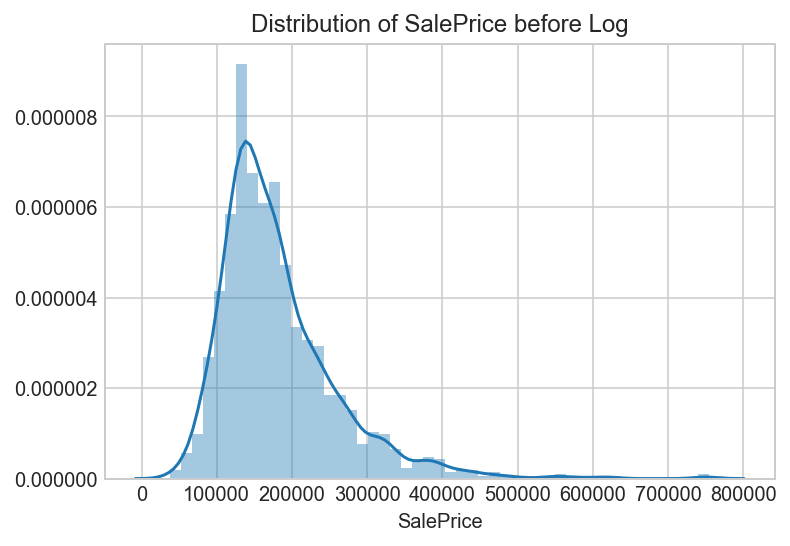

In [110]:
sns.distplot(house_f['SalePrice'])
plt.title('Distribution of SalePrice before Log')

Text(0.5,1,u'Distribution of SalePrice after Log')

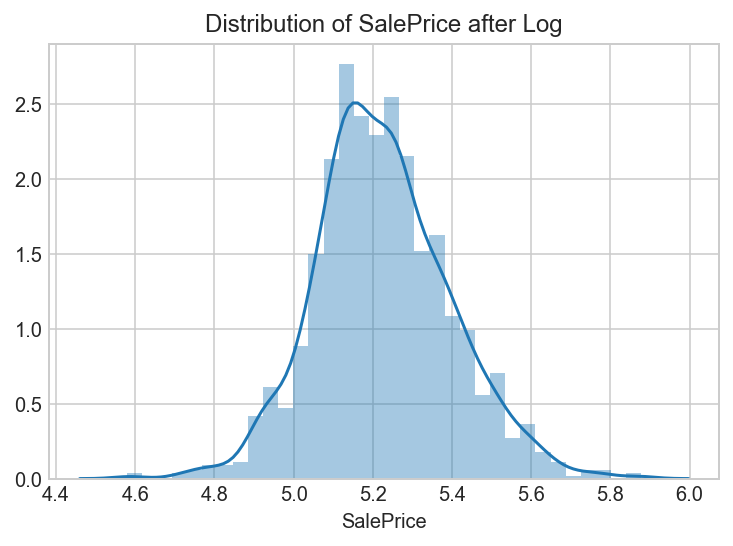

In [111]:
sns.distplot(house_f_standardize['SalePrice'])
plt.title('Distribution of SalePrice after Log')

In [112]:
house_f_standardize.head()

MSSubClass MSZoning  LotFrontage   LotArea       Age Street Alley LotShape  \
0          60       RL    -0.229641 -0.206899 -1.039579   Pave   NaN      Reg   
1          20       RL     0.451498 -0.092035 -0.174415   Pave   NaN      Reg   
2          60       RL    -0.093413  0.072772 -0.973028   Pave   NaN      IR1   
3          70       RL    -0.456687 -0.097029  1.822116   Pave   NaN      IR1   
4          60       RL     0.633135  0.373418 -0.939752   Pave   NaN      IR1   

  LandContour Utilities    ...     GarageArea WoodDeckSF OpenPorchSF  \
0         Lvl    AllPub    ...       0.351325  -0.754996    0.222301   
1         Lvl    AllPub    ...      -0.062427   1.618480   -0.713141   
2         Lvl    AllPub    ...       0.633429  -0.754996   -0.069066   
3         Lvl    AllPub    ...       0.793288  -0.754996   -0.176412   
4         Lvl    AllPub    ...       1.705424   0.774224    0.575009   

  EnclosedPorch 3SsnPorch ScreenPorch  PoolArea  MiscFeature   MiscVal  \
0     -0.354253 -0.116786   -0.270289 -0.068953          NaN -0.087203   
1     -0.354253 -0.116786   -0.270289 -0.068953          NaN -0.087203   
2     -0.354253 -0.116786   -0.270289 -0.068953          NaN -0.087203   
3      4.116770 -0.116786   -0.270289 -0.068953          NaN -0.087203   
4     -0.354253 -0.116786   -0.270289 -0.068953          NaN -0.087203   

   SalePrice  
0   5.319106  
1   5.258877  
2   5.349278  
3   5.146128  
4   5.397940  

[5 rows x 49 columns]

In [113]:
## For a direct comparison with house_f_standardize.head() above, on how numerical values are scaled 

house_f.select_dtypes(exclude='object').sample(5)

MSSubClass  LotFrontage  LotArea  Age  YrSinceRemod  MasVnrArea  \
978           20    83.000000    10159    1             0       450.0   
1133          20    70.057143     9000   49            49         0.0   
1026          20    70.057143    11500   52            52         0.0   
447           30    70.000000     5684   76             1         0.0   
1332          50    57.000000     7558   81            59         0.0   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea   ...    GarageArea  \
978          1930      1940         0       1940   ...           606   
1133         1006      1006         0       1006   ...             0   
1026            0       845         0        845   ...           290   
447           813       813         0        813   ...           270   
1332          896      1172       741       1913   ...           342   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
978          168           95              0          0            0   
1133           0           24              0          0            0   
1026         186            0              0          0            0   
447            0          113              0          0            0   
1332           0            0              0          0            0   

      PoolArea  MiscVal  SalePrice  YrSold  
978          0        0     395192    2010  
1133         0        0      80000    2008  
1026         0        0      84000    2009  
447          0        0     110000    2006  
1332         0        0     177000    2009  

[5 rows x 30 columns]

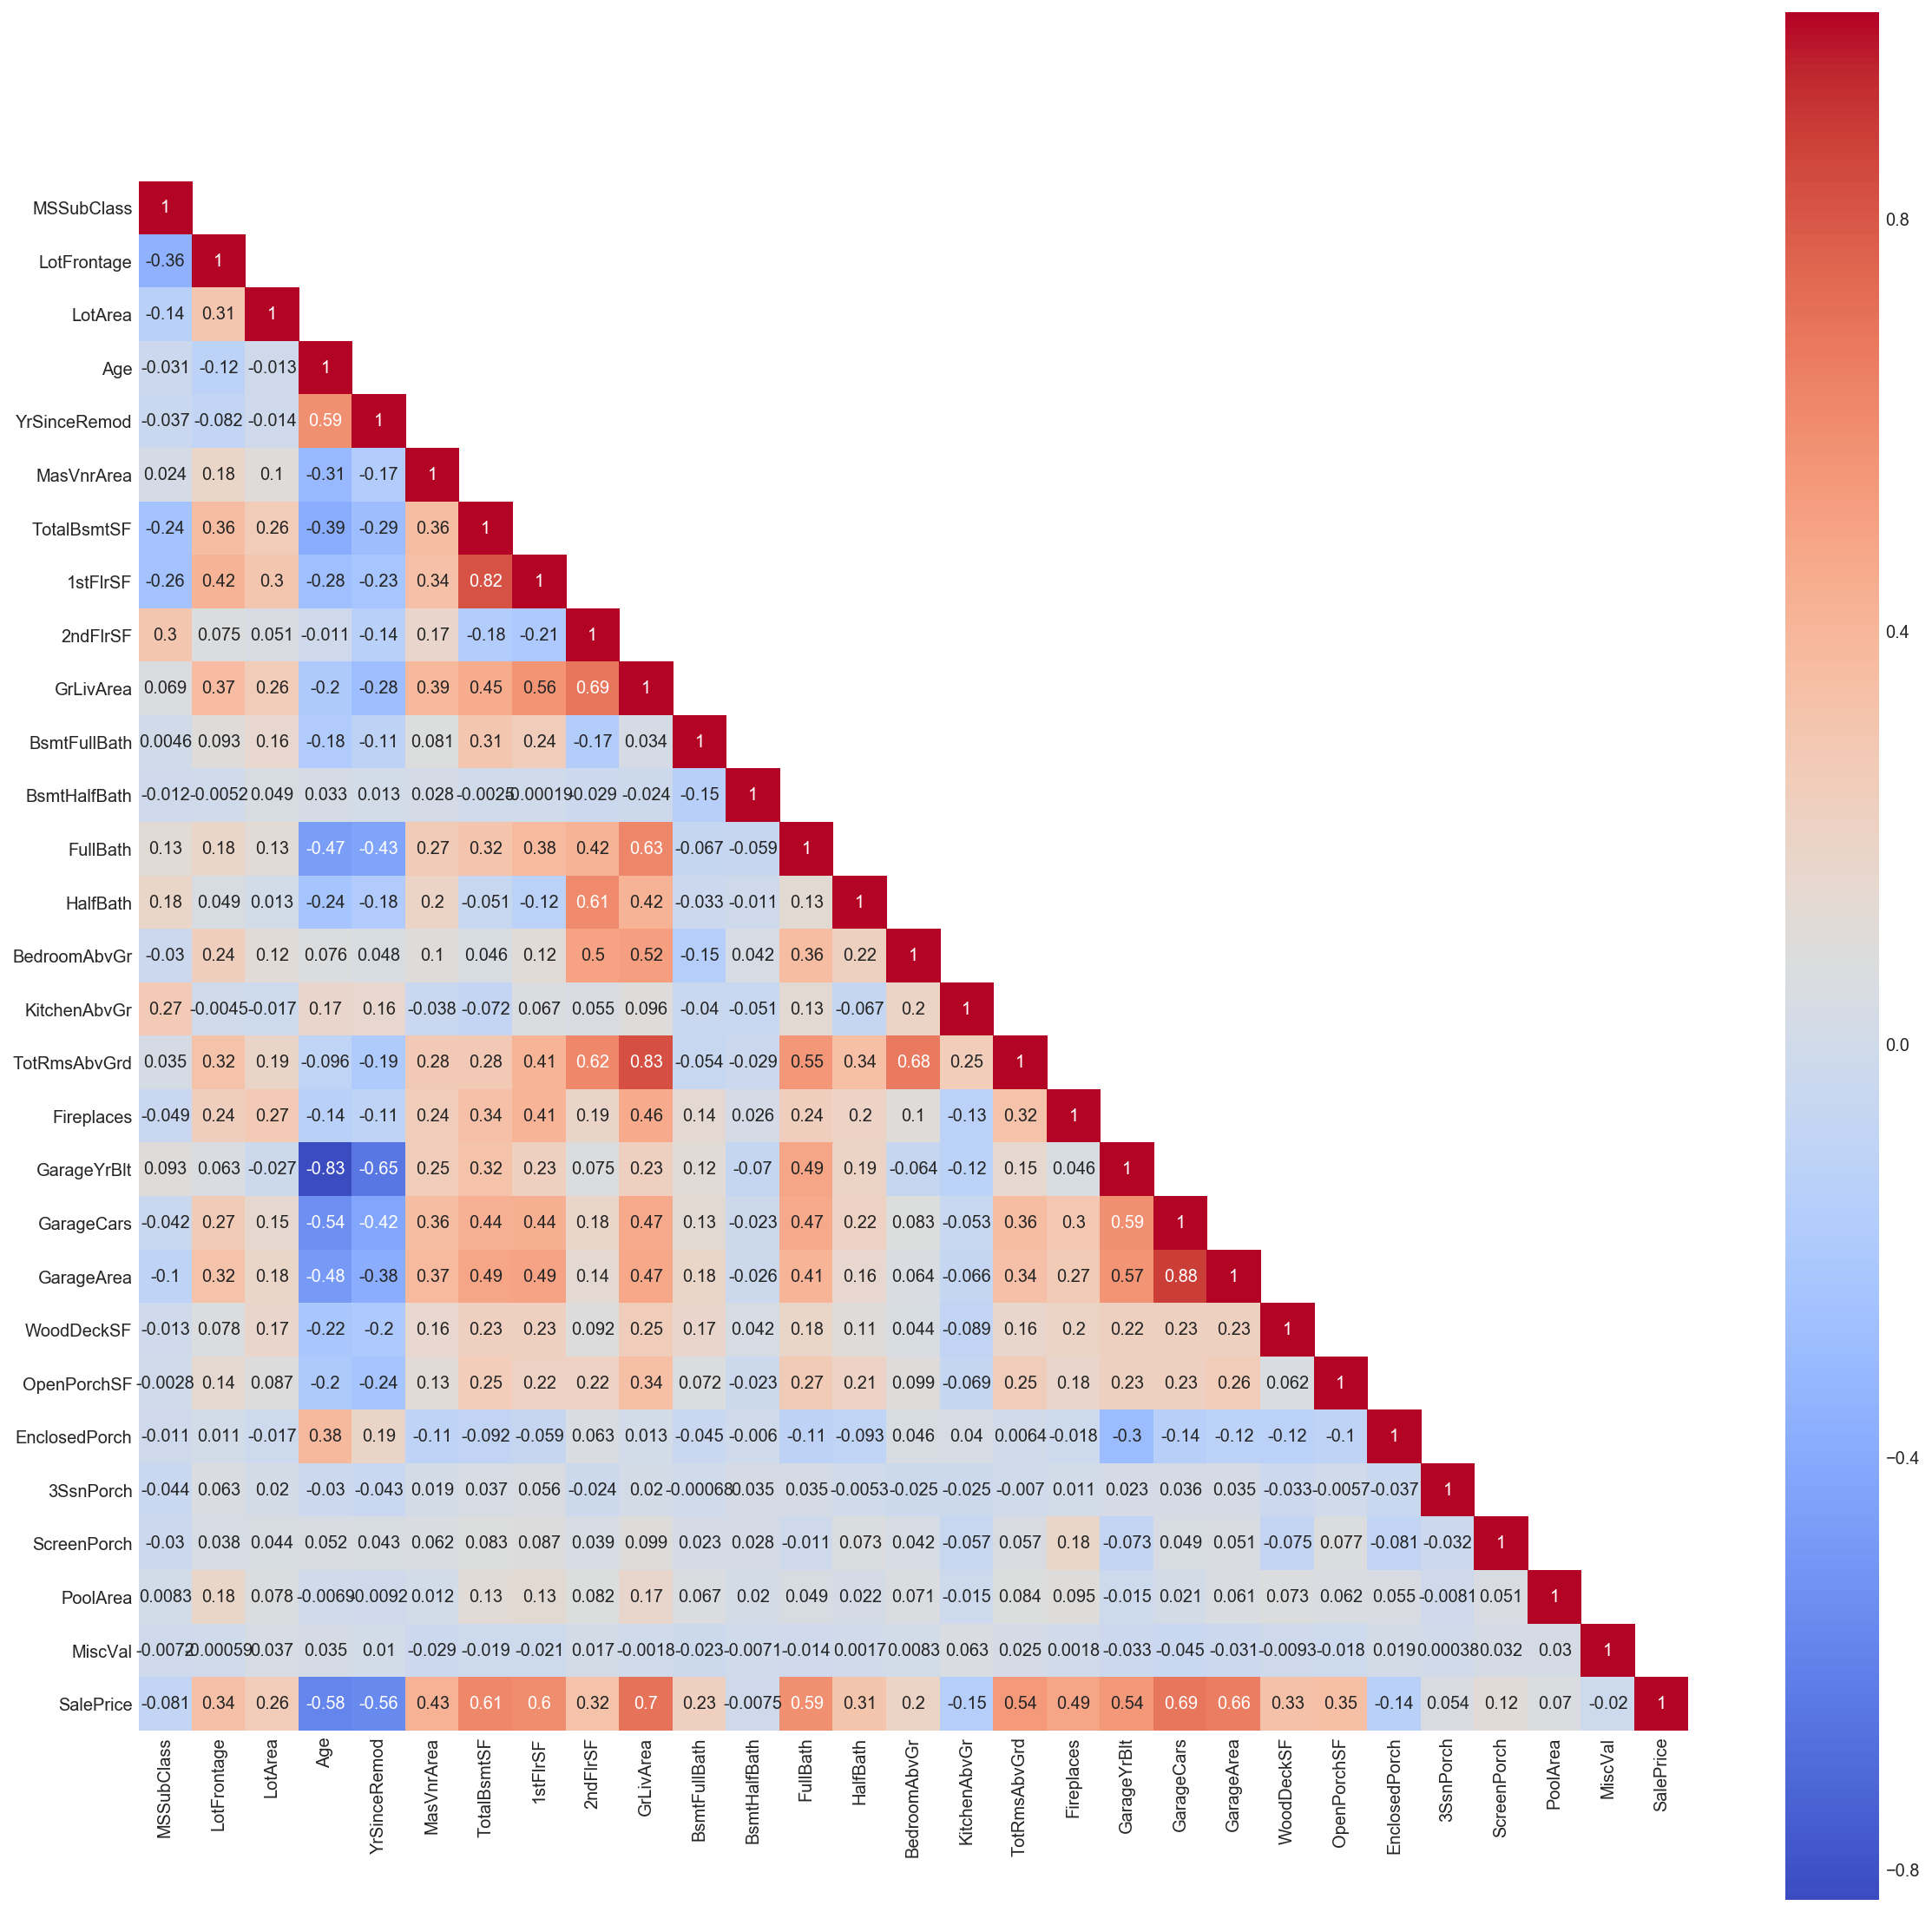

In [114]:
## Understanding correlation between the variables, especially in search of potential collinearity

plt.figure(figsize=(20,20))
mask = np.zeros_like(house_f_standardize.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] =True
mask[np.diag_indices_from(mask)] =False
sns.heatmap(house_f_standardize.corr(),square=True,cmap='coolwarm',mask = mask,annot=True)


Looking at the correlation coef heatmap above, other than SalePrice, if we spot significant correlation, we assume collinearity<br>
We take abs(corr coeff) >= 0.8 as to qualify as significant correlation 

In [115]:
## Age is quite linear to GarageYrBlt, suggesting collinearity, as such only Age is required
house_f_standardize.drop(labels=['GarageYrBlt'],axis=1,inplace=True)

## GarageCars is quite linear to GarageArea,suggesting collinearity ,as such only GarageCars is required to represent Garage space
house_f_standardize.drop(labels=['GarageArea'],axis=1,inplace=True)

## TotalRmsAbvGrd is quite linear to GrLivArea, suggesting collinearity, as such only GrLivArea is required to represent both
house_f_standardize.drop(labels=['TotRmsAbvGrd'],axis=1,inplace=True)

## -------SalePrice-----------
## MSSubClass, BsmtHalfBath, 3SsnPorch, PoolArea, MiscVal do not seem to be linearly related to SalePrice
house_f_standardize.drop(labels = ['MSSubClass','BsmtHalfBath','3SsnPorch','PoolArea','MiscVal'],axis=1,inplace=True)

#### Note
TotalBsmtSF is quite linear to 1stFlrSF, suggesting collinearity<br>
However, we have to keep in mind that one or the other cannot really represent each other as there are occasions where there is no basement<br>
As such we will keep both variables

In [116]:
## Creaing the binarized YrSold column for splitting into training and test set (pre 2010 vs 2010)

house_f_standardize['YrSold'] = house_f['YrSold'].apply(lambda x: 1 if x==2010 else 0)   #2010 = 1, not 2010 = 0

In [117]:
## Understand the values in the categorial data variables

for i, col in enumerate(house_f.select_dtypes(include=['object']).columns):
    print i+1, col
    print house_f.select_dtypes(include=['object'])[col].value_counts()
    print 'NaN values: ' + str(house_f.select_dtypes(include=['object'])[col].isnull().sum())
    print '--------------------'

1 MSZoning
RL    1150
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64
NaN values: 0
--------------------
2 Street
Pave    1445
Grvl       4
Name: Street, dtype: int64
NaN values: 0
--------------------
3 Alley
Grvl    50
Pave    39
Name: Alley, dtype: int64
NaN values: 1360
--------------------
4 LotShape
Reg    916
IR1    482
IR2     41
IR3     10
Name: LotShape, dtype: int64
NaN values: 0
--------------------
5 LandContour
Lvl    1304
Bnk      62
HLS      49
Low      34
Name: LandContour, dtype: int64
NaN values: 0
--------------------
6 Utilities
AllPub    1448
NoSeWa       1
Name: Utilities, dtype: int64
NaN values: 0
--------------------
7 LotConfig
Inside     1043
Corner      261
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
NaN values: 0
--------------------
8 LandSlope
Gtl    1374
Mod      62
Sev      13
Name: LandSlope, dtype: int64
NaN values: 0
--------------------
9 Neighborhood
NAmes      225
CollgCr    149
OldTown    112
Edwar

In [118]:
## Binarize catagorial datas with only 2 categories(including NaN)

## Street --- Pave: 1 , Grvl: 0 
house_f_standardize['Street'].replace(to_replace = ['Pave','Grvl'],value=[1,0],inplace = True)

## Utilities --- AllPub: 1 , NoSeWa: 0 
house_f_standardize['Utilities'].replace(to_replace = ['AllPub','NoSeWa'],value=[1,0],inplace = True)

In [119]:
## Creating a function to visualize value counts of each categorial data

def check_plot(var):
    sns.barplot(x = house_f_standardize[var].value_counts().to_frame().index ,y = var,data = house_f_standardize[var].value_counts().to_frame())
    plt.title('Number of each category in {}'.format(var))

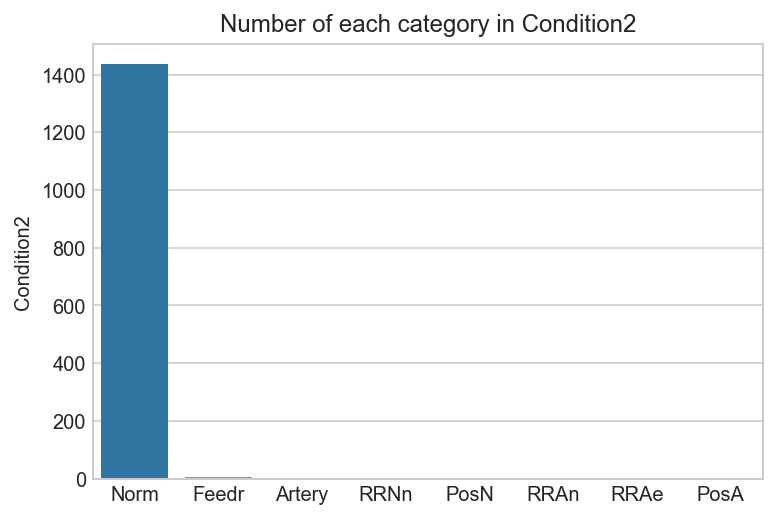

In [120]:
check_plot('Condition2')

In [121]:
## Some multi cat. variables can be binarized to most occurring cat vs others

## Condition2 --- Norm:1 , Not Norm: 0
house_f_standardize['Condition2'].replace(to_replace = ['Norm', 'Feedr','Artery','RRNn','PosN','RRAn','RRAe','PosA'],value=[1,0,0,0,0,0,0,0],regex=True,inplace = True)


In [122]:
## Creating a dataframe of dummy variables from the categorial fixed characteristics
## dataframe to be merged with house_f_standardize later

fixed_dummies = pd.DataFrame(index=range(0,house_f_standardize.shape[0]))

for col in house_f_standardize.columns:
    if house_f_standardize[col].dtypes == 'object':   # if column is categorial,i.e object type
        fixed_dummies = fixed_dummies.merge(pd.get_dummies(house_f_standardize[col],prefix=col,dummy_na=True,drop_first=True),left_index=True,right_index=True)  # merge the newly created dummy variables to main dummy dataframe

In [123]:
fixed_dummies['SalePrice'] = house_f_standardize['SalePrice']  # Adding saleprice to main dummy dataframe
del(house_f_standardize['SalePrice'])    # Deleting saleprice in house_f_standardize, so that saleprice will not be sandwiched between numerical variables and dummy variables when merged

In [124]:
## Merging dummy dataframe to house_f_standardize
    
house_f_standardize = house_f_standardize.merge(fixed_dummies,left_index=True,right_index=True)  

In [125]:
## Dropping categorial data columns, i.e objects, since they have already been made dummy variable and merged

house_f_standardize.drop(labels= house_f_standardize.select_dtypes(include='object').columns,axis=1,inplace=True)    

In [126]:
house_f_standardize.head(3)

LotFrontage   LotArea       Age  Street  Utilities  Condition2  \
0    -0.229641 -0.206899 -1.039579       1          1           1   
1     0.451498 -0.092035 -0.174415       1          1           1   
2    -0.093413  0.072772 -0.973028       1          1           1   

   YrSinceRemod  MasVnrArea  TotalBsmtSF  1stFlrSF    ...      \
0     -0.865672    0.508976    -0.463334 -0.799099    ...       
1      0.400471   -0.573018     0.461084  0.251084    ...       
2     -0.816974    0.321283    -0.317613 -0.633553    ...       

   GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   

   GarageType_Detchd  GarageType_nan  MiscFeature_Othr  MiscFeature_Shed  \
0                  0               0                 0                 0   
1                  0               0                 0                 0   
2                  0               0                 0                 0   

   MiscFeature_TenC  MiscFeature_nan  SalePrice  
0                 0                1   5.319106  
1                 0                1   5.258877  
2                 0                1   5.349278  

[3 rows x 131 columns]

In [127]:
## Creating the training dataset, i.e pre-2010 or YrSold=0

X_global_train = house_f_standardize[house_f_standardize['YrSold']==0].iloc[:,:-1]  # Predictors - All columns except -1 (SalePrice)
y_global_train = house_f_standardize[house_f_standardize['YrSold']==0]['SalePrice']  # Target - SalePrice

In [128]:
## YrSold column not required
## Dropping YrSold column, which in the middle of all the columns in predictors
## YrSold might act as a predictor, hence drop it

X_global_train.drop(labels='YrSold',axis=1,inplace=True)

In [129]:
## Creating the testing dataset, i.e 2010 or YrSold=1

X_global_test = house_f_standardize[house_f_standardize['YrSold']==1].iloc[:,:-1]  # Predictors - All columns except -1 (SalePrice)
y_global_test = house_f_standardize[house_f_standardize['YrSold']==1]['SalePrice']   # Target - SalePrice

In [130]:
## YrSold column not required
## Dropping YrSold column, which in the middle of all the columns in predictors
## YrSold might act as a predictor, hence drop it

X_global_test.drop(labels='YrSold',axis=1,inplace=True)

### <u>Feature Selection</u>

Recursive Feature Elimination is used as I want to features selected based on their importance and overall contribution to the performance of the linear model. <br>
This is suitable as it will conserve the required significant features, rather than choosing the KBest (which is most likely set arbitarily in this context).

The LASSO regularization will be used as the estimator due to its ability to set less-important predictors to 0 and help with choosing the predictors that can be left out of the model.

In [131]:
## Feature selection on a RFECV, with simple Cross Validated Lasso Regularized Linear Regression as estimator

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV

ls = LassoCV(cv=5,random_state=42)          # 5 fold CV
rfe_selector = RFECV(estimator=ls,cv=5,step=1)    ## 5 fold CV
rfe_selector.fit(X_global_train,y_global_train)
mask = rfe_selector.get_support()
rfecv_columns = X_global_train.columns[mask]
rfecv_columns

## Returns features/columns selected to be used in LinearRegression model

Index([u'LotFrontage', u'LotArea', u'Age', u'Condition2', u'YrSinceRemod',
       u'TotalBsmtSF', u'GrLivArea', u'BsmtFullBath', u'FullBath', u'HalfBath',
       u'KitchenAbvGr', u'Fireplaces', u'GarageCars', u'WoodDeckSF',
       u'ScreenPorch', u'MSZoning_RL', u'MSZoning_RM', u'LotShape_IR2',
       u'LotShape_IR3', u'LandContour_HLS', u'LandContour_Lvl',
       u'LotConfig_CulDSac', u'LotConfig_FR2', u'LandSlope_Sev',
       u'Neighborhood_BrkSide', u'Neighborhood_Crawfor',
       u'Neighborhood_Edwards', u'Neighborhood_Gilbert',
       u'Neighborhood_MeadowV', u'Neighborhood_Mitchel',
       u'Neighborhood_NWAmes', u'Neighborhood_NoRidge',
       u'Neighborhood_NridgHt', u'Neighborhood_OldTown',
       u'Neighborhood_Sawyer', u'Neighborhood_Somerst',
       u'Neighborhood_StoneBr', u'Neighborhood_Veenker', u'Condition1_Feedr',
       u'Condition1_Norm', u'Condition1_RRAe', u'BldgType_Duplex',
       u'BldgType_Twnhs', u'BldgType_TwnhsE', u'HouseStyle_2Story',
       u'RoofStyle_Gab

In [132]:
## Building the training predictors dataset's with selected features from RFECV

X_1 = pd.DataFrame()   # Feature selected training predictors dataframe
for col in rfecv_columns:
    X_1[col] = X_global_train[col]

In [133]:
## Building the testing predictors dataset's with selected features from RFECV

X_2 = pd.DataFrame()     # Feature selected test predictors dataframe
for col in rfecv_columns:
    X_2[col] = X_global_test[col]

### <u>Building the Model</u>

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

lm = LinearRegression()

## Testing the features in a cross validated linear regression in the training set

print 'cross validated R-Square = ', np.mean(cross_val_score(lm,X_1,y_global_train,cv=5))

cross validated R-Square =  0.8517150435533072


With the selected features, the initial cross validated LinearRegression model does give a good R-squared result in the training data.<br>
Therefore, proceed to continue using this model and fit to the training set, then testing it

In [135]:
## Fitting the model
model = lm.fit(X_1,y_global_train)

## Testing the model
print 'Test R-Square = ', model.score(X_2,y_global_test)

Test R-Square =  0.8923612686357477


#### Preliminary conclusion
The linear regression prediction model built with the features selected are able to predict and explain 0.8924 of the testing dataset, therefore the model is performing well

In [136]:
## Corresponding Coeff and their features

zip(model.coef_,X_1.columns)

[(-0.00608526886870549, 'LotFrontage'),
 (0.009235374865338444, 'LotArea'),
 (-0.01795647782932465, 'Age'),
 (0.0463073658816099, 'Condition2'),
 (-0.02448580951299636, 'YrSinceRemod'),
 (0.00223873706304647, 'TotalBsmtSF'),
 (0.06234797814997834, 'GrLivArea'),
 (0.013203393726219311, 'BsmtFullBath'),
 (0.01133723257645465, 'FullBath'),
 (0.005851451857189181, 'HalfBath'),
 (-0.0072690985894722955, 'KitchenAbvGr'),
 (0.013434473686875111, 'Fireplaces'),
 (0.020326230920277622, 'GarageCars'),
 (0.005089200788283156, 'WoodDeckSF'),
 (0.007470928306611464, 'ScreenPorch'),
 (0.006855493412239334, 'MSZoning_RL'),
 (-0.014445962869992354, 'MSZoning_RM'),
 (0.01858338819402568, 'LotShape_IR2'),
 (-0.06433924451920404, 'LotShape_IR3'),
 (0.03130283526716754, 'LandContour_HLS'),
 (0.02168040965229383, 'LandContour_Lvl'),
 (0.0168044542799234, 'LotConfig_CulDSac'),
 (-0.02170419361105984, 'LotConfig_FR2'),
 (-0.061839895284336664, 'LandSlope_Sev'),
 (0.011903612322899711, 'Neighborhood_BrkSide')

In [137]:
## Intercept of model

model.intercept_

5.141140543494894

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

# Ans:
## <font color = 'green'>Starting Note:</font>
This question is about inference from a linear model

In [138]:
# A:
## Building a target matrix in term of residuals from previous model, in the scale of the dollars

predictor_house_f_stand = pd.DataFrame()

for col in rfecv_columns:
    predictor_house_f_stand[col] = house_f_standardize[col]
    
y_hat = 10**model.predict(predictor_house_f_stand)    # Converting predicted value to dollars as question want changes in dollars

residual = house_f['SalePrice'] - y_hat

## Residual will be the target

Text(0.5,1,u'Distribution of Residuals')

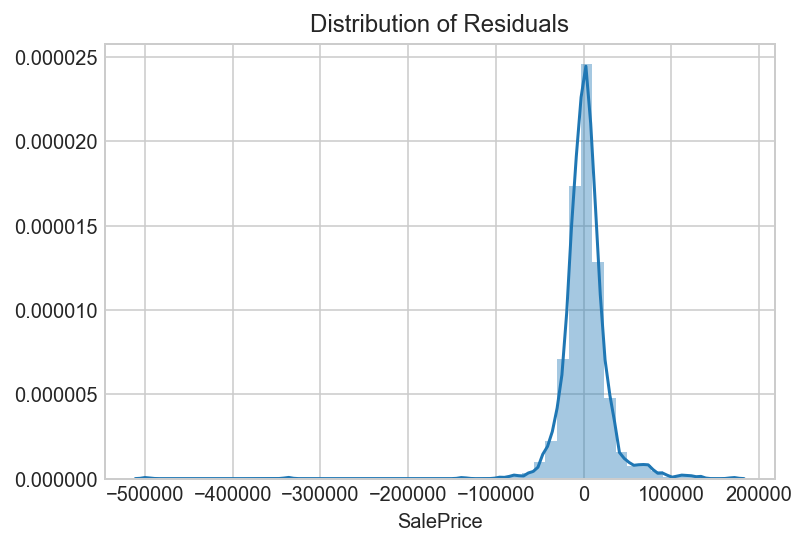

In [139]:
## Checking distribution of residuals to ensure no anomalies etc

sns.distplot(residual)
plt.title('Distribution of Residuals')

In [140]:
## Getting the remaining variables that were not fixed variables
fixed_feat = ['MSSubClass', 'MSZoning', 'LotFrontage','LotArea', 'Age','Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YrSinceRemod', 'RoofStyle', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal','SalePrice','YrSold']

house_nf = pd.DataFrame()     # house_nf is a DataFrame to contain non-fixed characteristics
for col in house.columns:
    if col not in fixed_feat:
        house_nf[col] = house[col]
 

In [141]:
house_nf.head()

Id  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofMatl Exterior1st  \
0   1            7            5       2003          2003  CompShg     VinylSd   
1   2            6            8       1976          1976  CompShg     MetalSd   
2   3            7            5       2001          2002  CompShg     VinylSd   
3   4            7            5       1915          1970  CompShg     Wd Sdng   
4   5            8            5       2000          2000  CompShg     VinylSd   

  Exterior2nd MasVnrType ExterQual      ...      FireplaceQu GarageFinish  \
0     VinylSd    BrkFace        Gd      ...              NaN          RFn   
1     MetalSd       None        TA      ...               TA          RFn   
2     VinylSd    BrkFace        Gd      ...               TA          RFn   
3     Wd Shng       None        TA      ...               Gd          Unf   
4     VinylSd    BrkFace        Gd      ...               TA          RFn   

  GarageQual  GarageCond PavedDrive  PoolQC  Fence MoSold SaleType  \
0         TA          TA          Y     NaN    NaN      2       WD   
1         TA          TA          Y     NaN    NaN      5       WD   
2         TA          TA          Y     NaN    NaN      9       WD   
3         TA          TA          Y     NaN    NaN      2       WD   
4         TA          TA          Y     NaN    NaN     12       WD   

  SaleCondition  
0        Normal  
1        Normal  
2        Normal  
3       Abnorml  
4        Normal  

[5 rows x 33 columns]

In [142]:
## Removing features that are not related to being renovatable, upgrade to the building

house_nf.drop(labels=['Id','YearBuilt','YearRemodAdd','MoSold','SaleType','SaleCondition'],axis=1,inplace=True)

In [143]:
## Adding the residual column to house_nf for later reference and train test splitting convenience

house_nf['Residual'] = residual

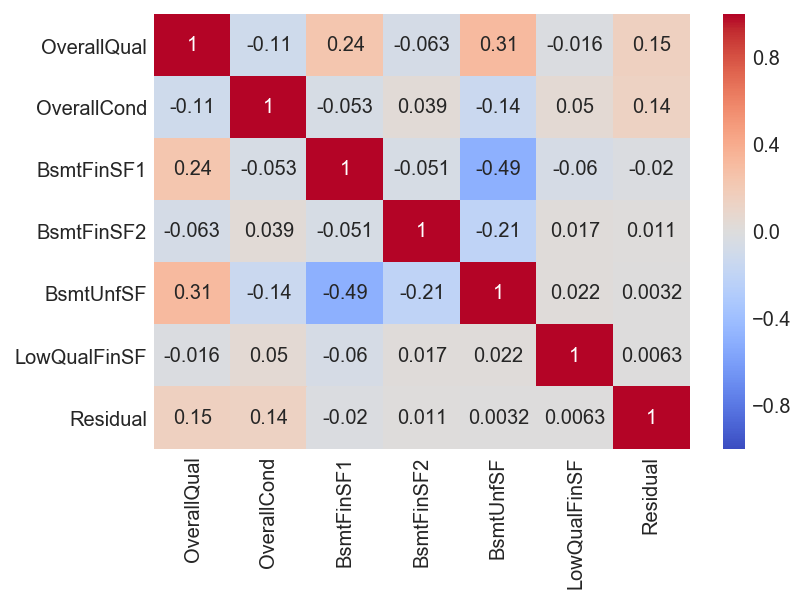

In [144]:
## Understanding correlation between the variables, especially in search of potential collinearity

sns.heatmap(house_nf.corr(),cmap='coolwarm',vmin=-1.0,annot=True)

Note: Not much linear relation observed between variables from heatmap

In [145]:
## Understand the categorial value spreads in each categorial column

for col in house_nf.columns:
    print house_nf[col].value_counts()
    print '--------------------'

5     396
6     373
7     318
8     168
4     111
9      43
10     18
3      18
2       2
1       2
Name: OverallQual, dtype: int64
--------------------
5    818
6    250
7    204
8     72
4     54
3     24
9     22
2      4
1      1
Name: OverallCond, dtype: int64
--------------------
CompShg    1423
Tar&Grv      11
WdShngl       6
WdShake       5
Membran       1
Metal         1
ClyTile       1
Roll          1
Name: RoofMatl, dtype: int64
--------------------
VinylSd    514
HdBoard    222
MetalSd    215
Wd Sdng    204
Plywood    107
CemntBd     61
BrkFace     49
WdShing     26
Stucco      25
AsbShng     19
Stone        2
BrkComm      2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64
--------------------
VinylSd    503
MetalSd    209
HdBoard    207
Wd Sdng    195
Plywood    141
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     24
AsbShng     19
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd

In [146]:
## Renaming values that has names that might be problematic when creating dummy variable columns

house_nf['Exterior1st'].replace(to_replace=['Wd Sdng','Wd Shng'],value = ['Wd_Sdng','Wd_Shng'],inplace = True)
house_nf['Exterior2nd'].replace(to_replace=['Brk Cmn','Wd Shng'],value = ['Brk_Cmn','Wd_Shng'],inplace = True)

### Modifying the features and their values

In [147]:
## Binarize Central Air since it contains 2 categories only, Y & N

house_nf['CentralAir'] = house_nf['CentralAir'].apply(lambda x: 1 if x=='Y' else 0)

Most of the following features are descriptive rating scales, as such it will be appropriate to convert them to numerical ratings scale<br>
These numerical ratings can provide an insight in house an improvement or decrease of 1 on the rating scale can either increase/reduce the target by the coefficient multiplied rating jump

In [148]:
## Assign numerical ratings(weightage) to Ex/Gd/TA/Fa/Po rating

def num_weight_rate(x):
    if x == 'Po':
        return 1
    elif x == 'Fa':
        return 2
    elif x == 'TA':
        return 3
    elif x == 'Gd':
        return 4
    elif x == 'Ex':
        return 5
    else:
        return 0

house_nf['ExterQual'] = house_nf['ExterQual'].apply(num_weight_rate)
house_nf['ExterCond'] = house_nf['ExterCond'].apply(num_weight_rate)
house_nf['BsmtCond'] = house_nf['BsmtCond'].apply(num_weight_rate)
house_nf['HeatingQC'] = house_nf['HeatingQC'].apply(num_weight_rate)
house_nf['KitchenQual'] = house_nf['KitchenQual'].apply(num_weight_rate)
house_nf['FireplaceQu'] = house_nf['FireplaceQu'].apply(num_weight_rate)
house_nf['GarageQual'] = house_nf['GarageQual'].apply(num_weight_rate)
house_nf['GarageCond'] = house_nf['GarageCond'].apply(num_weight_rate)
house_nf['PoolQC'] = house_nf['PoolQC'].apply(num_weight_rate)

In [149]:
## Assign numerical ratings(weightage) to rating in BsmtFinType1/2

def num_weight_rate_2(x):
    if x == 'Unf':
        return 1
    elif x == 'LwQ':
        return 2
    elif x == 'Rec':
        return 3
    elif x == 'BLQ':
        return 4
    elif x == 'ALQ':
        return 5
    elif x == 'GLQ':
        return 6
    else:
        return 0
    
house_nf['BsmtFinType1'] = house_nf['BsmtFinType1'].apply(num_weight_rate_2)
house_nf['BsmtFinType2'] = house_nf['BsmtFinType2'].apply(num_weight_rate_2)

In [150]:
## Assign numerical ratings(weightage) to ratings in GarageFinish and PavedDrive

def gar_weight_rate(x):
    if x == 'Unf':
        return 1
    elif x == 'RFn':
        return 2
    elif x == 'Fin':
        return 3
    else:
        return 0
    
house_nf['GarageFinish'] = house_nf['GarageFinish'].apply(gar_weight_rate)


def pave_weight_rate(x):
    if x == 'N':
        return 1
    elif x == 'P':
        return 2
    elif x == 'Y':
        return 3
    else:
        return 0
    
house_nf['PavedDrive'] = house_nf['PavedDrive'].apply(pave_weight_rate)    


In [151]:
## Creating a dataframe of dummy variables from the categorial non-fixed characteristics
## dataframe to be merged with house_nf later

nonfixed_dummies = pd.DataFrame(index=range(0,house_nf.shape[0]))

for col in house_nf.columns:
    if house_nf[col].dtypes == 'object':     # if column is categorial,i.e object type
        nonfixed_dummies = nonfixed_dummies.merge(pd.get_dummies(house_nf[col],prefix=col,dummy_na=True,drop_first=True),left_index=True,right_index=True)     # merge the newly created dummy variables to main dummy dataframe

In [152]:
nonfixed_dummies.columns

Index([u'RoofMatl_CompShg', u'RoofMatl_Membran', u'RoofMatl_Metal',
       u'RoofMatl_Roll', u'RoofMatl_Tar&Grv', u'RoofMatl_WdShake',
       u'RoofMatl_WdShngl', u'RoofMatl_nan', u'Exterior1st_AsphShn',
       u'Exterior1st_BrkComm', u'Exterior1st_BrkFace', u'Exterior1st_CBlock',
       u'Exterior1st_CemntBd', u'Exterior1st_HdBoard', u'Exterior1st_ImStucc',
       u'Exterior1st_MetalSd', u'Exterior1st_Plywood', u'Exterior1st_Stone',
       u'Exterior1st_Stucco', u'Exterior1st_VinylSd', u'Exterior1st_WdShing',
       u'Exterior1st_Wd_Sdng', u'Exterior1st_nan', u'Exterior2nd_AsphShn',
       u'Exterior2nd_BrkFace', u'Exterior2nd_Brk_Cmn', u'Exterior2nd_CBlock',
       u'Exterior2nd_CmentBd', u'Exterior2nd_HdBoard', u'Exterior2nd_ImStucc',
       u'Exterior2nd_MetalSd', u'Exterior2nd_Other', u'Exterior2nd_Plywood',
       u'Exterior2nd_Stone', u'Exterior2nd_Stucco', u'Exterior2nd_VinylSd',
       u'Exterior2nd_Wd Sdng', u'Exterior2nd_Wd_Shng', u'Exterior2nd_nan',
       u'MasVnrType_BrkF

In [153]:
## Merging the dummies to the main house_nf dataframe

house_nf = house_nf.merge(nonfixed_dummies,left_index=True,right_index=True)

In [154]:
## Dropping columns in house_nf that have been made dummy variable

house_nf.drop(labels = ['RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Heating','Electrical','Fence','Residual'],axis=1,inplace=True)

<img src= "https://emojipedia-us.s3.amazonaws.com/thumbs/120/apple/129/warning-sign_26a0.png" style="float: left; margin: 15px; height: 40px"><br>
## Proceed to next cell carefully, please do not run next cell

-

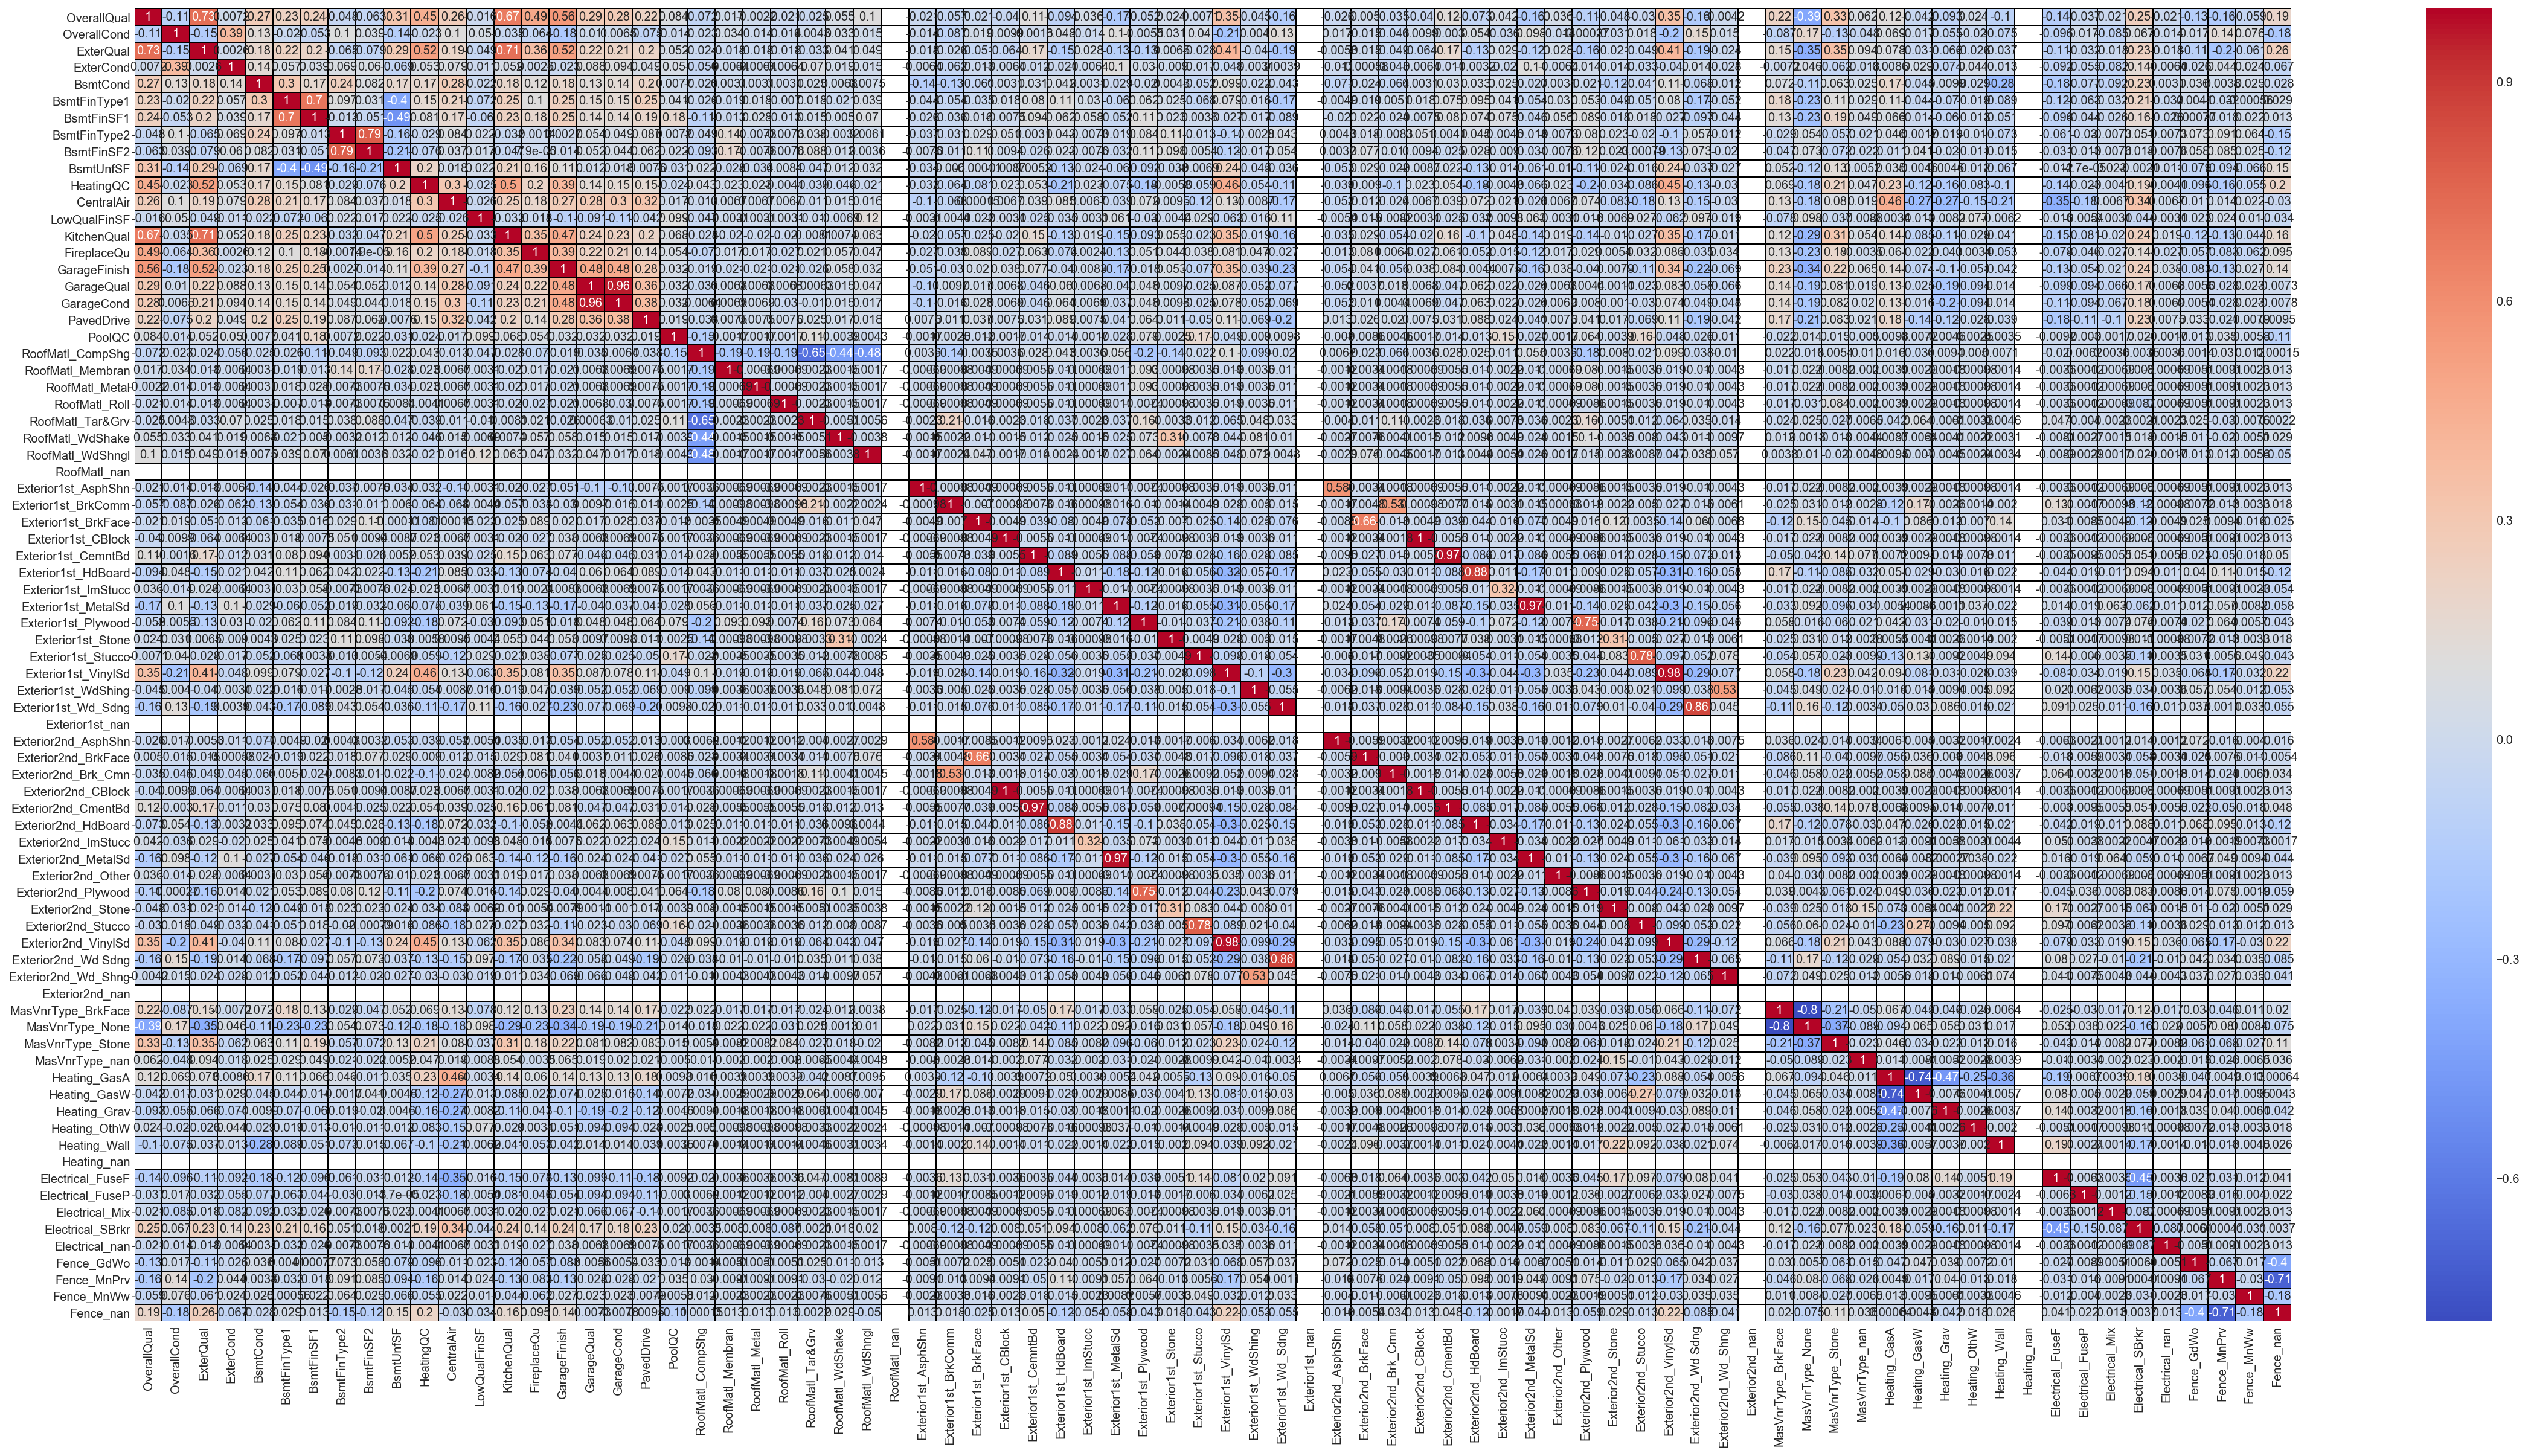

In [217]:
##### !!!!Do not run this cell again due to huge computing load to plot!!!!


plt.figure(figsize=(40,20))
sns.heatmap(house_nf.corr(),cmap='coolwarm',linecolor='black',linewidths=0.5,annot=True)

In [155]:
house_nf.columns

Index([u'OverallQual', u'OverallCond', u'ExterQual', u'ExterCond', u'BsmtCond',
       u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2', u'BsmtFinSF2',
       u'BsmtUnfSF', u'HeatingQC', u'CentralAir', u'LowQualFinSF',
       u'KitchenQual', u'FireplaceQu', u'GarageFinish', u'GarageQual',
       u'GarageCond', u'PavedDrive', u'PoolQC', u'RoofMatl_CompShg',
       u'RoofMatl_Membran', u'RoofMatl_Metal', u'RoofMatl_Roll',
       u'RoofMatl_Tar&Grv', u'RoofMatl_WdShake', u'RoofMatl_WdShngl',
       u'RoofMatl_nan', u'Exterior1st_AsphShn', u'Exterior1st_BrkComm',
       u'Exterior1st_BrkFace', u'Exterior1st_CBlock', u'Exterior1st_CemntBd',
       u'Exterior1st_HdBoard', u'Exterior1st_ImStucc', u'Exterior1st_MetalSd',
       u'Exterior1st_Plywood', u'Exterior1st_Stone', u'Exterior1st_Stucco',
       u'Exterior1st_VinylSd', u'Exterior1st_WdShing', u'Exterior1st_Wd_Sdng',
       u'Exterior1st_nan', u'Exterior2nd_AsphShn', u'Exterior2nd_BrkFace',
       u'Exterior2nd_Brk_Cmn', u'Exterior2nd_CBl

#### Note:
1) Looking at the correlation heatmap, we observe that GarageCond and GarageQual are greatly correlated, hence collinearity. Therefore we should remove either GarageCond or GarageQual<br>
2) We can also observe that Exterior1st and Exterior2nd materials tend to be the same, therefore we can remove Exterior2nd froom consideration

In [156]:
## Dropping the columns as noted above

house_nf.drop(labels=[u'Exterior2nd_AsphShn', u'Exterior2nd_BrkFace',u'Exterior2nd_Brk_Cmn', u'Exterior2nd_CBlock', u'Exterior2nd_CmentBd',
       u'Exterior2nd_HdBoard', u'Exterior2nd_ImStucc', u'Exterior2nd_MetalSd',
       u'Exterior2nd_Other', u'Exterior2nd_Plywood', u'Exterior2nd_Stone',
       u'Exterior2nd_Stucco', u'Exterior2nd_VinylSd', u'Exterior2nd_Wd Sdng',
       u'Exterior2nd_Wd_Shng', u'Exterior2nd_nan','GarageCond'],axis=1,inplace=True)

In [157]:
## Creating a columns to show proportion of Total Bsmt Finished for each type

house_nf['Prop_BsmtFinSF1'] = house_nf['BsmtFinSF1']/house['TotalBsmtSF']
house_nf['Prop_BsmtFinSF2'] = house_nf['BsmtFinSF2']/house['TotalBsmtSF']

## Proportion of Bsmt Finished for each type will be used as a measure replacing BsmtFinSF and BsmtUnfSF

house_nf.drop(labels=['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'],axis=1,inplace=True)

In [158]:
## Filling some null values with 0

house_nf.fillna(value=float(0),inplace=True)

### Feature Selection

With this challenge, we are required to make inference on how changes in renovatable variables will affect the sale price.<br>
To make the model more intepretable, we select the best 20 variables that affect the price residual.<br>
For this, we use SelectKBest of k=20, and f_regression score function which is suitable for regressions

In [161]:
from sklearn.feature_selection import SelectKBest,f_regression

selector = SelectKBest(f_regression,k=20)
selector.fit(house_nf,residual)
mask = selector.get_support()
selected_columns = house_nf.columns[mask]
selected_columns

C:\ProgramData\Anaconda3\envs\py27_\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: invalid value encountered in divide
  corr /= X_norms
C:\ProgramData\Anaconda3\envs\py27_\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\py27_\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\py27_\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Index([u'OverallQual', u'OverallCond', u'ExterQual', u'ExterCond',
       u'BsmtFinType1', u'HeatingQC', u'CentralAir', u'KitchenQual',
       u'FireplaceQu', u'PoolQC', u'RoofMatl_Membran', u'RoofMatl_WdShngl',
       u'Exterior1st_BrkFace', u'Exterior1st_CemntBd', u'Exterior1st_HdBoard',
       u'Exterior1st_Stucco', u'Heating_GasW', u'Heating_Grav', u'Fence_GdWo',
       u'Prop_BsmtFinSF1'],
      dtype='object')

In [162]:
## Creating predictor dataframe X with selected features

X = pd.DataFrame()
for col in selected_columns:
    X[col] = house_nf[col]

In [163]:
## The target variable
y = pd.Series(residual)

### Model

In [164]:
## Using Statsmodels Ordinary Least Squares Model because of the summary table it generates

import statsmodels.api as sm

X = sm.add_constant(X) # Adding const
model = sm.OLS(y,X).fit()

C:\ProgramData\Anaconda3\envs\py27_\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [165]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     8.659
Date:                Fri, 06 Jul 2018   Prob (F-statistic):           1.02e-24
Time:                        11:33:46   Log-Likelihood:                -16852.
No. Observations:                1449   AIC:                         3.375e+04
Df Residuals:                    1428   BIC:                         3.386e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.064e+04   8448.141     -4.810      0.000   -5.72e+04   -2.41e+04
OverallQual          3661.5585    870.323      4.207      0.000    1954.309    5368.808
OverallCond          4100.2657    727.437      5.637      0.000    2673.306    5527.226
ExterQual            -339.8502   2137.125     -0.159      0.874   -4532.091    3852.391
ExterCond           -1334.6122   2265.471     -0.589      0.556   -5778.620    3109.396
BsmtFinType1          222.9901    560.146      0.398      0.691    -875.807    1321.787
HeatingQC            -182.6912    959.463     -0.190      0.849   -2064.799    1699.416
CentralAir           -605.7550   3520.418     -0.172      0.863   -7511.500    6299.990
KitchenQual           862.8834   1698.872      0.508      0.612   -2469.670    4195.437
FireplaceQu          -876.4754    461.778     -1.898      0.058   -1782.312      29.362
PoolQC              -1.328e+04   2735.974     -4.853      0.000   -1.86e+04   -7910.148
RoofMatl_Membran     6.098e+04   2.75e+04      2.217      0.027    7018.798    1.15e+05
RoofMatl_WdShngl     4.803e+04   1.13e+04      4.236      0.000    2.58e+04    7.03e+04
Exterior1st_BrkFace  1.953e+04   4078.317      4.788      0.000    1.15e+04    2.75e+04
Exterior1st_CemntBd  3037.1418   3675.344      0.826      0.409   -4172.511    1.02e+04
Exterior1st_HdBoard -3229.3842   2121.000     -1.523      0.128   -7389.993     931.225
Exterior1st_Stucco  -1.003e+04   5743.583     -1.747      0.081   -2.13e+04    1231.779
Heating_GasW         1.366e+04   7083.164      1.928      0.054    -237.692    2.76e+04
Heating_Grav        -7731.0083   1.09e+04     -0.707      0.479   -2.92e+04    1.37e+04
Fence_GdWo          -3830.4669   3891.090     -0.984      0.325   -1.15e+04    3802.399
Prop_BsmtFinSF1      3630.3262   3316.079      1.095      0.274   -2874.584    1.01e+04
==============================================================================
Omnibus:                     1446.511   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           328748.189
Skew:                          -4.159   Prob(JB):                         0.00
Kurtosis:                      76.321   Cond. No.                         452.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Conclusion:

Other than Constant, OverallCond, OverallQual, PoolQC, RoofMatl_Membran, RoofMatl_WdShngl, Exterior1st_BrkFace, the other coeffs for the selected features are > pvalue, therefore we cannot reject the null hypothesis that the true coeff is 0 and these features do not affect the residual.<br><br>
With a very low R-square of 0.038, it is unreliable to use renovatable features in linear regression to determine and explain the residuals.<br><br>
Therefore, more than 0.95 of the residuals is possibly due to irreducible error.<br>
I will recommend against using this model for the company as we cannot reliability use selected renovatable features to predict the residuals

--------------------------------------------------------------

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

# Ans:

In [166]:
# A:

## Proportion of houses with Abnormal sale condition

print 'Abnorml: ',float(house['SaleCondition'].value_counts()['Abnorml'])/house['SaleCondition'].value_counts().sum()

print 'Not Abnorml: ',1 - float(house['SaleCondition'].value_counts()['Abnorml'])/house['SaleCondition'].value_counts().sum()

Abnorml:  0.06625258799171843
Not Abnorml:  0.9337474120082816


It is evident that there is severe class imbalance in that Abnorml is a very small minority class of the dataset.

One solution to this challenge is sampling, as explained below.
<a href= https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2> Source </a>
####  <u>Sampling</u>
A simple way to fix imbalanced data-sets is simply to balance them, either by oversampling instances of the minority class or undersampling instances of the majority class. This simply allows us to create a balanced data-set that, in theory, should not lead to classifiers biased toward one class or the other. However, in practice, these simple sampling approaches have flaws. Oversampling the minority can lead to model overfitting, since it will introduce duplicate instances, drawing from a pool of instances that is already small. Similarly, undersampling the majority can end up leaving out important instances that provide important differences between the two classes.

There also exist more powerful sampling methods that go beyond simple oversampling or undersampling. The most well known example of this is SMOTE, which actually creates new instances of the minority class by forming convex combinations of neighboring instances. As the graphic below shows, it effectively draws lines between minority points in the feature space, and samples along these lines. This allows us to balance our data-set without as much overfitting, as we create new synthetic examples rather than using duplicates. This however does not prevent all overfitting, as these are still created from existing data points.

<img src =https://cdn-images-1.medium.com/max/800/1*uAiwqUNhqaSZmsXCrl9kVQ.png>


As such we will build a classification model, with sampling to on the target class.



In [167]:
## Binarize Abnorml and Others

house['SaleCondition_AbnormlClass'] = house['SaleCondition'].apply(lambda x: 1 if x=='Abnorml' else 0)

## Creating a new dataFrame of unified processed/standardized predictor dataframes from Qns 1 and 2

house_class = house_f_standardize.merge(house_nf,left_index=True,right_index=True)

## Adjoining the Binarized SaleCondition(Abnorml/NotAbnorml) to the new dataframe

house_class = house_class.merge(house[['SaleCondition_AbnormlClass']],left_index=True, right_index=True)

In [168]:
## Creating pre-upsampled predictor and target dataframes

X_Orig = house_class.iloc[:,:-1].copy()

y_Orig= house_class['SaleCondition_AbnormlClass'].copy()

In [169]:
from sklearn.model_selection import train_test_split

X = house_class.iloc[:,:-1]
y = house_class['SaleCondition_AbnormlClass']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 142)

### SMOTE

In [170]:
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = smt.fit_sample(X_train, y_train)

C:\ProgramData\Anaconda3\envs\py27_\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [171]:
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV(cv=5,penalty='l2')
model = lr.fit(X_train_res,y_train_res)
prediction_lr = model.predict(X_test)

In [172]:
from sklearn.metrics import roc_auc_score,roc_curve

In [173]:
## Checking how the model performs on the test dataset

roc_auc_score(y_test,prediction_lr)

0.5095884507649213

In [176]:
from sklearn.metrics import classification_report,auc

In [178]:
print (classification_report(y_test,prediction_lr))

             precision    recall  f1-score   support

          0       0.94      0.78      0.86       273
          1       0.06      0.24      0.10        17

avg / total       0.89      0.75      0.81       290



On the test set:<br>
While the AUC performs close to baseline of 0.5, it does well in to recall 0.75 of the true positives in the test set, and predicts positives quite accurately with 0.89 precision

In [174]:
## Checking how the model performs on the entire original dataset

prediction_orig = model.predict(X_Orig)

In [175]:
roc_auc_score(y_Orig,prediction_orig)

0.8167498152254249

In [177]:
print (classification_report(y_Orig,prediction_orig))

             precision    recall  f1-score   support

          0       0.98      0.84      0.91      1353
          1       0.26      0.79      0.39        96

avg / total       0.93      0.84      0.87      1449



## Conclusion:
The model does not perform classification well, quite possibly due to inappropriate feature selection, rather than model selection.<br>
Additionally, the model hyperparameters should be further optimized

Below, I explore <a href= "https://github.com/samsonleegh/">Samson's</a> method with Random Forest, while still using SMOTE

--------------------------------------------

In [642]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
   'n_estimators':[5,15,20],
   'criterion':["gini", "entropy"],
   'max_features':['auto','sqrt'],
   "min_samples_split": [2, 3, 10],
   "min_samples_leaf": [1, 3, 10],
}

clf = RandomForestClassifier()
clf_gridsearch = GridSearchCV(clf, param_grid, cv=5, verbose=1)
clf_gridsearch.fit(X_train_res, y_train_res)
#output
print clf_gridsearch.best_score_
print clf_gridsearch.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
0.9699074074074074
{'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 20, 'criterion': 'gini', 'min_samples_leaf': 1}


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   48.9s finished


In [643]:
#predict score
best_clf = clf_gridsearch.best_estimator_
best_clf.score(X_test, y_test)

0.9344827586206896

In [644]:
#predict probability
Y_pp = pd.DataFrame(best_clf.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
#roc, auc for model for common performance measurement

# For class 1, find the area under the curve.
fpr, tpr, _ = roc_curve(y_test, Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

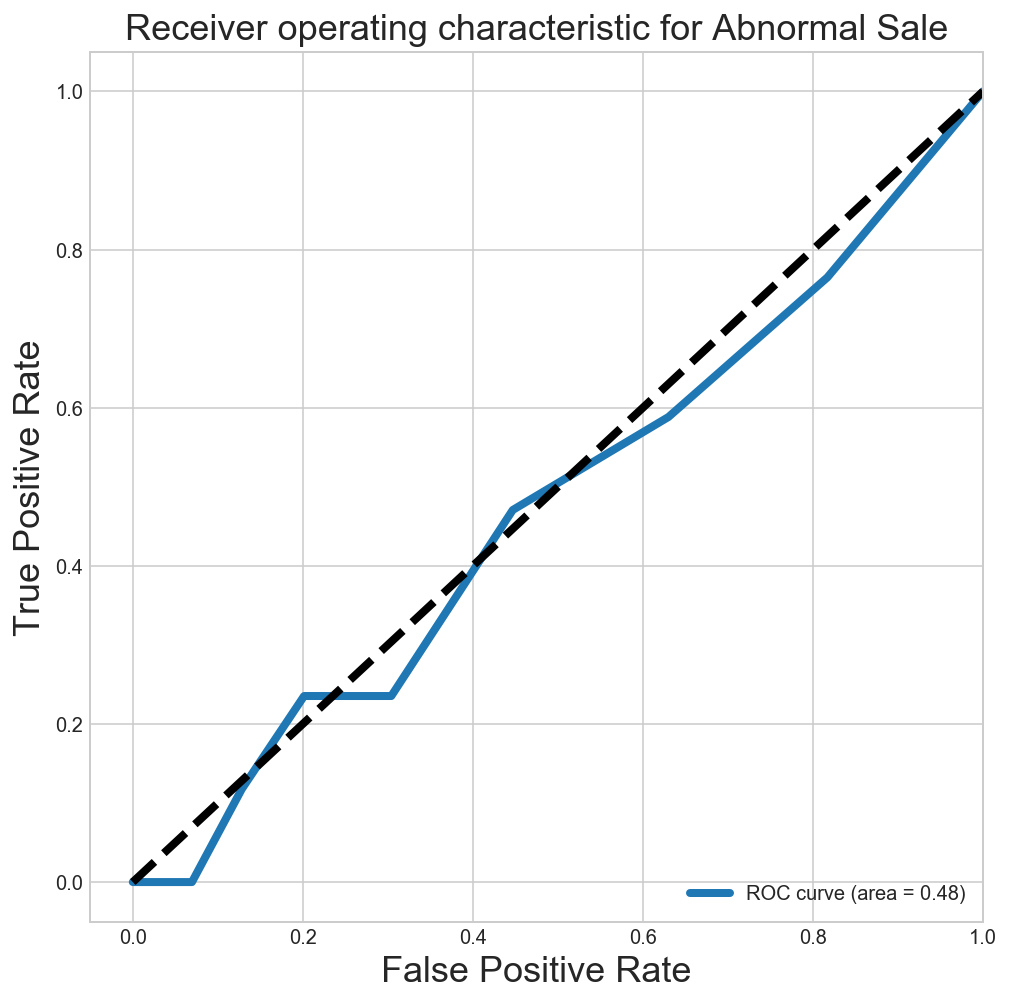

auc: 0.475867269984917


In [645]:
# Plot of a ROC curve for class 1 (abnormal sale).
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Abnormal Sale', fontsize=18)
plt.legend(loc="lower right")
plt.show()
print 'auc:',roc_auc

----------------------------------------------